In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
import scipy.stats as stats

from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [2]:
def analysis(col, tops = 10):
    temp = train[col].value_counts()
    temp = temp.iloc[:tops].index
    #temp = train.index
    temp_df = train[train[col].isin(temp)]
#     prob = temp_df[col].value_counts(normalize=True)
#     draw = np.random.choice(prob.index, p=prob, size=len(temp_df))
#     output = pd.Series(draw).value_counts(normalize=True).rename('simulated')
#     zeros = set(temp_df[col].dropna().unique()).difference(set(output.index))
#     output = output.append(pd.Series([0 for i in zeros], index = zeros)) / (temp_df[col].value_counts())
    temp_df['shuffle'] = temp_df['HasDetections'].sample(replace=False, n=len(temp_df)).reset_index(drop=True)
    output = temp_df[temp_df['shuffle'] == 1][col].value_counts() / temp_df[col].value_counts()
    pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts()/ temp_df[col].value_counts(),
                         'random_data': output}).plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {} (most of the catogaries)'.format(col))
    
    display(pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts()/ temp_df[col].value_counts(),
                         'random_data': output}))
    return stats.ks_2samp(temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                output)




#stats.chi2_contingency([temp_df.groupby(col).HasDetections.mean(),
#                temp_df.groupby(col).random_data.mean()])


In [3]:
COLS = [
    'HasDetections',
    'Platform',
    'OsBuild'
]

In [4]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=COLS)

In [5]:
train.head()

,Platform,OsBuild,HasDetections
0,windows10,17134,0
1,windows10,17134,0
2,windows10,17134,0
3,windows10,17134,1
4,windows10,17134,1


,train_data,random_data
windows10,0.500032,0.499803
windows8,0.506720,0.500540
windows7,0.486511,0.498930
windows2016,0.349593,0.489040


Ks_2sampResult(statistic=0.75, pvalue=0.10749046502096637)

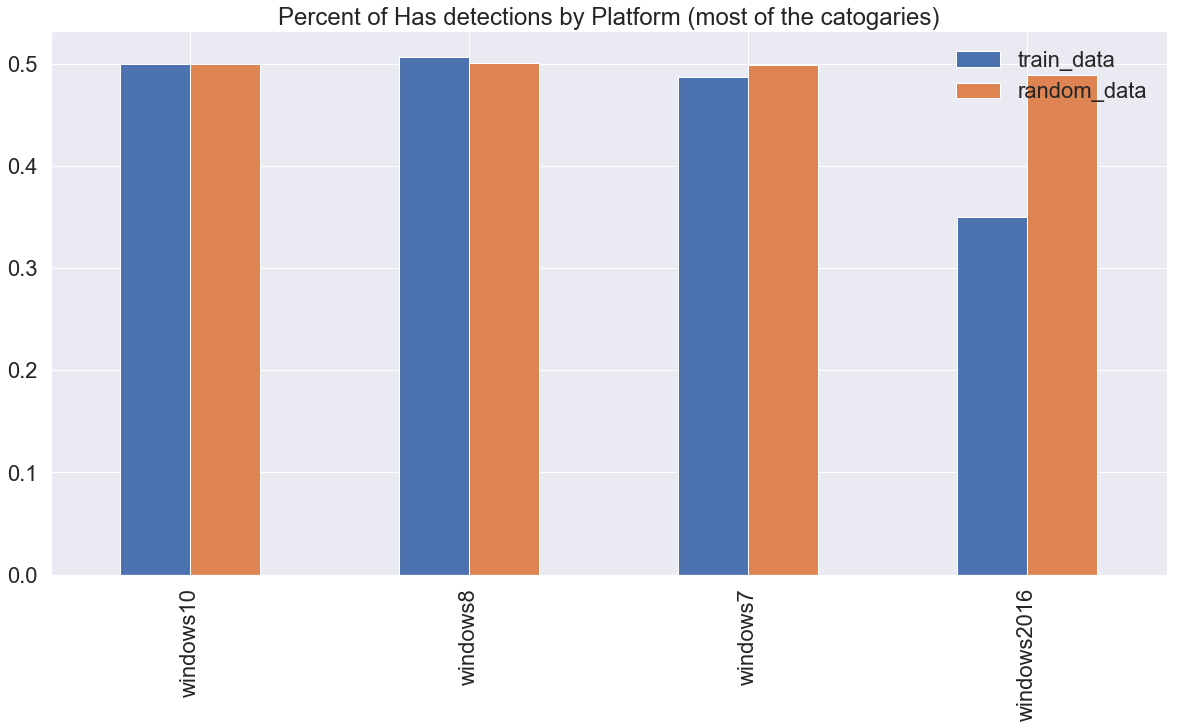

In [6]:
analysis(COLS[1])

In [7]:
# virius and platform is not likely revelent

,train_data,random_data
17134,0.520727,0.498950
16299,0.492128,0.498968
15063,0.478875,0.499143
14393,0.462269,0.499039
10586,0.465831,0.500046
10240,0.486584,0.499478
9600,0.506720,0.497872
7601,0.486432,0.499368
17692,0.443467,0.499058
17738,0.445117,0.502421


Ks_2sampResult(statistic=1.0, pvalue=1.8879793657162556e-05)

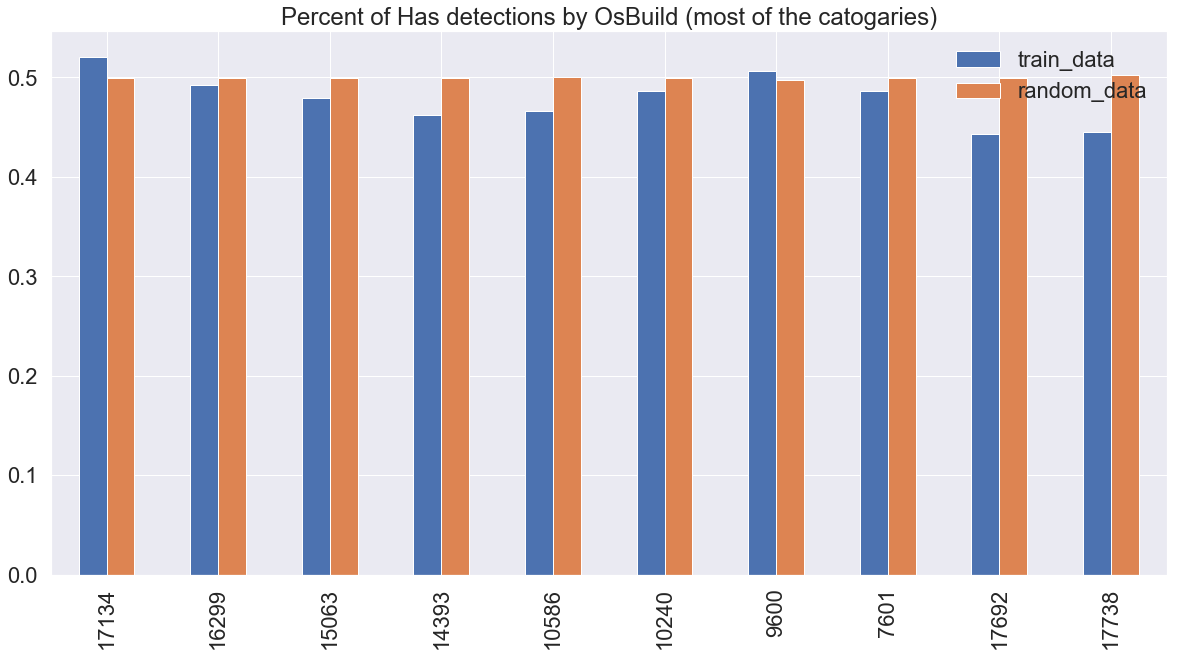

In [8]:
analysis(COLS[2])

In [9]:
# We assmue malware detection may have no significant relation with operating system

In [10]:
# random forest clustering to comfirm

In [11]:
def skl(col):
    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preproc = ColumnTransformer(transformers=[('onehot', nominal_transformer, col)],\
                                          remainder='drop')
    clf = RandomForestClassifier(n_estimators=7, max_depth=60)
    pl = Pipeline(steps=[('preprocessor', preproc),
                    ('clf', clf)
                    ])
    return pl

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train.dropna().drop('HasDetections',axis = 1)\
                                                    , train.dropna()['HasDetections'], test_size=0.25)
N = len(y_test)
y_random = y_test.sample(replace=False, frac = 1)

In [13]:
output = pd.DataFrame(columns = ['Observation accuracy', 'Random_Data accuracy'], index = COLS[1:])
for i in COLS[1:]:
    pl = skl([i])
    pl.fit(X_train, y_train)
    pred_score = pl.score(X_test, y_test)
    rand_score = pl.score(X_test, y_random)
    output.loc[i, 'Observation accuracy'] = pred_score
    output.loc[i, 'Random_Data accuracy'] = rand_score
pl = skl(COLS[1:])
pl.fit(X_train, y_train)
pred_score = pl.score(X_test, y_test)
rand_score = pl.score(X_test, y_random)
output.loc['combined', 'Observation accuracy'] = pred_score
output.loc['combined', 'Random_Data accuracy'] = rand_score

In [14]:
output

,Observation accuracy,Random_Data accuracy
Platform,0.500503,0.500177
OsBuild,0.518036,0.500423
combined,0.518036,0.500423


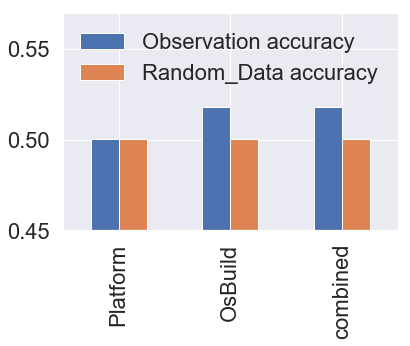

In [15]:
output.plot(kind = 'bar', ylim = (0.45, 0.57))

In [16]:
#Conclusion, In general, Operating system has a slightly influence to malware detection (not very significant)
#'OSBuild' will have a more significant influence when we proceed random forest clustering,
#and 'Platform' may have no affect to malware detection. When we combine two 'OSBuild' will dominate the
#clf. 